In [1]:
!wget -N http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

--2021-04-21 20:37:29--  http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘review_polarity.tar.gz’ not modified on server. Omitting download.



In [2]:
data = !tar xvzf review_polarity.tar.gz

In [3]:
# Splitting data into positive and negative reviews 

neg, pos = data[:1000], data[1000:2000]

In [4]:
# Part 1: Parsing the dataset

import numpy as np
import re
from numpy import linalg as LA

X_raw, y = [], []

for file in pos:
    with open(file, "r") as infile:
        review = ''
        sents = infile.read().split("\n")
        for sent in sents:
            review = review + sent
        review = re.sub(r'[^\w\s]', '', review)
        X_raw.append(review)
        y.append(1)

for file in neg:
    with open(file, "r") as infile:
        review = ''
        sents = infile.read().split("\n")
        for sent in sents:
            review = review + sent
        review = re.sub(r'[^\w\s]', '', review)
        X_raw.append(review)
        y.append(-1)
        

In [5]:
# Creating vocabulary

vocab = []
for review in X_raw:
    review_tok = (review.split())
    for token in review_tok:
        token = token.lower()
        if token not in vocab:
            vocab.append(token)
        else:
            pass
        
ordered_vocabulary = sorted(vocab)

In [6]:
# Part 2: Feature extraction - creating BOW vectors

X = []
for review in X_raw:
    review_tok = review.split()
    X_temp = []
    for word in ordered_vocabulary:
            if word in review_tok:
                X_temp.append(1)
            else:
                X_temp.append(0)
    X.append(X_temp)

X = np.array(X)
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1) # adding bias

In [16]:
# Splitting dataset into train and test (80/20)

y = np.array(y)

y_test = y[:200]
y_train = y[200:1800]
y_test = np.concatenate((y_test, y[1800:]), axis = 0)


X_test = X[:200]
X_train = X[200:1800]
X_test = np.concatenate((X_test, X[1800:]), axis = 0)


In [8]:
#Part 3: Learning framework

class classifier:

    def __init__(self, learning_rate, reguliser_dampening):  #initialing model 
        self.learning_rate = learning_rate
        self.reguliser_dampening = reguliser_dampening
        self.theta = np.zeros(X.shape[1])
        self.y_pred = []
        
    def fit(self, X, y):
        theta_old = np.ones(X.shape[1]) # initializing another theta for the comparison below
        num_correct = 0
        n = 0
        while not np.allclose(self.theta, theta_old, atol=0.1) and n != 200:   # stopping criteria - theta(t+1)} approx. = theta(t), if not converged, the model stops after 200 iterations
            n += 1
            y_pred = []
            for i in range(len(X)):
                y_hat = self.hyperplane(self.theta, X[i])
                y_pred.append(y_hat)
            for i in range(len(y_pred)):
                if y[i] == y_pred[i]:
                    num_correct += 1
            print("Accuracy", num_correct / len(y))
            print(f'Epoch {n}: {self.hinge_loss(self.theta, X, y)}')
            theta_old = self.theta
            self.theta = self.update_gradient(self.theta, X, y)
            num_correct = 0
        return theta_old

    def predict(self, X):  # predicting labels, the function takes a dataset as an argument 
        self.y_pred = []
        for i in range(len(X)):
            y_hat = self.hyperplane(self.theta, X[i])
            self.y_pred.append(y_hat)
        return self.y_pred

    def score(self, y): # takes a set of gold labels for a given data set as an argument and returns an accuracy score for the predicted labels
        num_correct = 0
        for i in range(len(self.y_pred)):
            if y[i] == self.y_pred[i]:
                num_correct += 1
        return num_correct / len(y)

    def hinge_loss(self, theta, X, y): # help function for calculating loss
            error = 0
            for i in range(len(X)):
                error += max(0, 1 - (y[i] * np.dot(theta.T, X[i])))
            return (self.reguliser_dampening/2 * np.square(LA.norm(theta))) + error

    def gradient(self, theta, X, y):  #helper function for calculating gradient
        s = np.copy(self.reguliser_dampening * theta)
        for i in range(len(X)):
            if (y[i] *(np.dot(theta.T, X[i]))) >= 1:
                s += 0
            else:
                s += (-y[i]*X[i])
        return s

    def update_gradient(self, theta, X, y): #helper function for updating theta
        new_t = theta - self.learning_rate * self.gradient(theta, X, y)
        return new_t

    def hyperplane(self, theta, x): 
        return np.sign(np.dot(theta.T, x))

    def show_theta(self):
        return self.theta


In [9]:
# Part 4: Exploring hyperparameters
import random
parameter_distribution = {'learning_rate': np.exp(np.linspace(np.log(0.0001), np.log(3), 10)),
                          'reguliser_dampening': np.exp(np.linspace(np.log(0.0001), np.log(3), 10))}

best_hyperparameters = None
print("Learning rate:\tReg.dampening:\tTraining set accuracy:")

for _ in range(5):
    lr = np.random.choice(parameter_distribution['learning_rate'])
    rd = np.random.choice(parameter_distribution['reguliser_dampening'])
           
    model = classifier(lr, rd)
    model.fit(X_train, y_train)
    
    training_accuracy = np.sum(model.predict(X_train)==y_train)/len(y_train)

    if best_hyperparameters is None or best_hyperparameters[1] < training_accuracy:
        best_hyperparameters = ((lr, rd), training_accuracy)
    print("%.5f\t\t%.5f\t\t%.1f%%" % (lr, rd, 100*training_accuracy))

best_learning_rate = best_hyperparameters[0][0]
best_reguliser_dampening = best_hyperparameters[0][1]
print("Best parameters: %.5f, %.5f" % (best_learning_rate, best_reguliser_dampening))
    

Learning rate:	Reg.dampening:	Training set accuracy:
Accuracy 0.0
Epoch 1: 1600.0
Accuracy 0.629375
Epoch 2: 2068.992037655888
Accuracy 0.5
Epoch 3: 126457.23881507388
Accuracy 0.5
Epoch 4: 22813.97169365417
Accuracy 0.5
Epoch 5: 119782.53678172478
Accuracy 0.5
Epoch 6: 25046.002795783992
Accuracy 0.5
Epoch 7: 113272.14647087116
Accuracy 0.5
Epoch 8: 27276.31715930045
Accuracy 0.5
Epoch 9: 106921.53144376792
Accuracy 0.5
Epoch 10: 29503.4868534799
Accuracy 0.5
Epoch 11: 100726.29413136406
Accuracy 0.5
Epoch 12: 31726.16411942013
Accuracy 0.5
Epoch 13: 94682.17124651761
Accuracy 0.5
Epoch 14: 33943.07790879529
Accuracy 0.5
Epoch 15: 88785.02935527769
Accuracy 0.5
Epoch 16: 36153.0305594037
Accuracy 0.5
Epoch 17: 83030.86060156763
Accuracy 0.5
Epoch 18: 38354.89460230216
Accuracy 0.5
Epoch 19: 77415.77857980042
Accuracy 0.50125
Epoch 20: 40547.60969551509
Accuracy 0.5
Epoch 21: 71936.01435016256
Accuracy 0.50125
Epoch 22: 42733.322195914116
Accuracy 0.5
Epoch 23: 66229.53817498065
Accura

In [10]:
model_best = classifier(3.00000, 0.00031) #initializing model with the best parameters found during the grid search
model_best.fit(X_train, y_train) # training the model

Accuracy 0.0
Epoch 1: 1600.0
Accuracy 0.629375
Epoch 2: 1338245.28893
Accuracy 0.5
Epoch 3: 102024165.34740797
Accuracy 0.5
Epoch 4: 38945909.3901945
Accuracy 0.5
Epoch 5: 96340007.36938192
Accuracy 0.5
Epoch 6: 40132212.732722364
Accuracy 0.5
Epoch 7: 90670591.21192735
Accuracy 0.5
Epoch 8: 41320477.01962011
Accuracy 0.5
Epoch 9: 85015873.96162094
Accuracy 0.5
Epoch 10: 42510683.12766879
Accuracy 0.5
Epoch 11: 79375812.84242527
Accuracy 0.5
Epoch 12: 43702812.02669845
Accuracy 0.5
Epoch 13: 73750365.21521828
Accuracy 0.5
Epoch 14: 44896844.77920147
Accuracy 0.5
Epoch 15: 68139488.57732628
Accuracy 0.5
Epoch 16: 46092762.53994733
Accuracy 0.5
Epoch 17: 62543140.56205727
Accuracy 0.5
Epoch 18: 47290546.55559934
Accuracy 0.5
Epoch 19: 56961278.93823703
Accuracy 0.5
Epoch 20: 48490178.164332554
Accuracy 0.501875
Epoch 21: 51411471.284392245
Accuracy 0.5
Epoch 22: 49095122.84562853
Accuracy 0.506875
Epoch 23: 46571243.479635075
Accuracy 0.5
Epoch 24: 48253714.77316949
Accuracy 0.514375
Epo

array([-383.61420193, -735.33697774, -159.98596281, ...,   80.96743784,
        -78.36592653,    0.        ])

In [11]:
model_best.predict(X_test) # predicting labels for the test set 
model_best.score(y_test) # checking accuracy on the test set

0.845

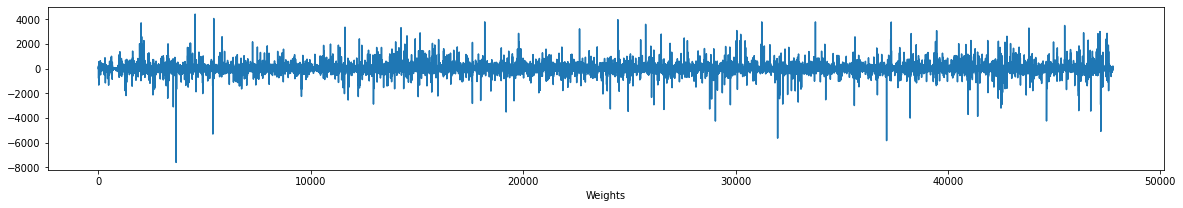

In [12]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(20, 3))
plt.plot(model_best.show_theta()[1:])
plt.xlabel("Value")
plt.xlabel("Weights")
plt.show()

In [15]:
assert (len(model.show_theta())-1) == len(vocab)

# Sort by absolute value
idx = np.argsort(np.abs(model_best.show_theta()[1:]))

print("                Word   Weight  Occurences")
for i in idx[-20:]:   # Pick those with highest 'voting' values
  print("%20s   %.3f\t%i " % (ordered_vocabulary[i], model_best.show_theta()[i+1], np.sum([ordered_vocabulary[i] in d for d in X_raw])))

                Word   Weight  Occurences
                many   3579.277	796 
        performances   3638.118	370 
                also   3694.805	1071 
              stupid   -3713.251	227 
                seen   3762.609	657 
               quite   3772.276	483 
             perfect   3773.761	403 
               great   3776.065	805 
            supposed   -3870.675	321 
                life   3951.407	895 
              should   -4009.455	708 
                both   4050.753	683 
       unfortunately   -4245.779	329 
             nothing   -4253.538	594 
                best   4404.417	867 
               worst   -5087.688	238 
              boring   -5304.696	229 
                plot   -5637.429	1002 
              script   -5836.344	632 
                 bad   -7600.511	825 


I have implemented the classifier as a class with three main functions 
– fit, for training the model, predict for predicting the labels by the model, 
and score for checking the accuracy obtained on the predicted labels. 
To be able to run the aforementioned functions I have created additional helper functions, 
e.g. for updating the feature vector and calculating the hinge loss, which are used while training the model. 
The hyper-parameters were chosen during the grid search – the function iterates five times and chooses 
different pairs consisting of learning_rate and reguliser_dampening and chooses the pair that gives 
the highest accuracy on the train set. In my case, the best hyper-parameters were: 
learning_rate 3.00000 and reguliser_dampening = 0.00031 (I am unsure if these are the right hyper-parameters since the loss is high, but 
I decided to stick to the parameters found during the search). 
As far as weights are concerned, the terms that mostly influenced rating a review as negative were “bad”, “worst”, “boring” 
but, surprisingly, also “plot” and “script”. When it comes down to positive reviews some of the terms that had the most impact on labelling 
a review as positive were “best”, “great”, but also “life”. 